# Model & Testing Creation Notebook

In this notebook we will be creating and testing different models to use for food label prediction

### Setup - Import Necessary Libraries & Data for Model Training

In [ ]:
# Install required packages if not already done
! pip install -r notebook_requirements.txt

In [4]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import torch libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision

# Import extra libraries
from tqdm.auto import tqdm
import os
import requests
from pathlib import Path

/Users/axel/foodvision_replica/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/axel/foodvision_replica/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [31]:
# Import Food101 Dataset to 'data' folder
data_dir = Path("data")

train_data = torchvision.datasets.Food101(root=data_dir, split="train",
                                          download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.Food101(root=data_dir, split="test",
                                        download=True, transform=torchvision.transforms.ToTensor())

100.0%


Extracting data/food-101.tar.gz to data


### Define Utility Functions

In [60]:
def train_step(model, train_dataloader, optimizer, loss_fn):
    """Carry out training step for one epoch"""

    loss, acc = 0.0, 0.0

    model.train()
    for i, (images, labels) in enumerate(train_dataloader):

        # Make predictions
        y_logits = model(images)  # Forward propagation
        y_probs = y_logits.softmax(dim=1)  # Calculate predicted probabilities

        batch_loss = loss_fn(y_logits, labels)  # Calculate loss of predicitions
        batch_acc = (y_probs.argmax(dim=1) == labels).sum().item() / len(y_probs)

        # Update model
        optimizer.zero_grad()   # Reset optimizer gradient
        batch_loss.backward()   # Carry out back-propagation
        optimizer.step()   # Update model weights

        loss += (batch_loss.item() - loss) / (i+1)  # Update cumulative epoch loss
        acc += (batch_acc - acc) / (i+1)  # Update cumulative epoch accuracy

    return loss, acc


In [52]:
def eval_step(model, val_dataloader, loss_fn):
    """Carry out the evaluation step for an epoch of training"""
    loss, acc = 0.0, 0.0
    
    model.eval()
    with torch.inference_mode():
        for i, (images, labels) in enumerate(val_dataloader):
            
            # Calculate predictions, predictions loss, & predictions accuracy
            y_logits = model(images)    # Carry out Forward Propagation
            y_probs = y_logits.softmax(dim=1)
            batch_loss = loss_fn(y_logits, labels)    # Calculate batch loss
            batch_acc = (y_probs.argmax(dim=1) == labels).sum().item()/len(y_logits) # Calculate batch accuracy

            # Update cumulative loss
            loss += (batch_loss.detach().item() - loss) / (i + 1)
            acc += (batch_acc - acc)/(i+1)
            
    return loss, acc


In [53]:
def train_model(model, num_epochs, train_dataloader, val_dataloader, optimizer, loss_fn):
    """Carry out entire model training process for the specified number of epochs"""

    # Create lists in which to store training & testing loss and accuracy
    train_losses, val_losses = [], []  
    train_accuracies, val_accuracies = [], []
    
    for epoch in tqdm(range(num_epochs)):
        
        # Get training loss & accuracy
        training_loss, training_acc = train_step(model, train_dataloader, optimizer, loss_fn)
        train_losses.append(training_loss)
        train_accuracies.append(training_acc)
        
        # Get validation loss & accuracy
        validation_loss, validation_acc = eval_step(model, val_dataloader, loss_fn)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_acc)

    return_dict = {"training_losses" : train_losses, "validation_losses" : val_losses,
                   "training_accuracies" : train_accuracies, "validation_accuracies" : val_accuracies}
    
    return return_dict


In [68]:
def plot_loss_curves(train_losses : list, val_losses : list):
    """
    Plot the training and validation loss curves
    
    Args:
    train_losses (list) : list containing the training loss for each epoch
    val_losses (list) : list containing the validation loss for each epoch
    """
    
    fig, ax = plt.subplots(1,2, figsize=(6,4))
    ax[0].plot(train_losses)
    ax[0].set_title("Training Loss Curve")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epoch")
    
    ax[1].plot(val_losses)
    ax[1].set_title("Validation Loss Curve")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    
    fig.tight_layout()
    plt.show()

def plot_accuracy_curves(train_accs : list, val_accs : list):
    """
    Plot the training and validation loss curves
    
    Args:
    train_losses (list) : list containing the training loss for each epoch
    val_losses (list) : list containing the validation loss for each epoch
    """
    
    fig, ax = plt.subplots(1,2, figsize=(6,4))
    ax[0].plot(train_accs)
    ax[0].set_title("Training Accuracy Curve")
    ax[0].set_ylim(0,1)
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epoch")
    
    ax[1].plot(val_accs)
    ax[1].set_title("Validation Accuracy Curve")
    ax[1].set_ylim(0,1)
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    
    fig.tight_layout()
    plt.show()

### Create Baseline Model
The Baseline Model we use will be an EfficientNet B0 Model w/ Adjusted Classifier trained on 20% of training dataset

In [55]:
# Import EfficientNet B0 model w/ pretrained weights
effnet_b0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnet_b0_transforms = effnet_b0_weights.transforms()

effnet_b0_model = torchvision.models.efficientnet_b0(weights=effnet_b0_weights)
for param in effnet_b0_model.parameters():  # Freeze internal parameters
    param.requires_grad = False
effnet_b0_model.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                           nn.Linear(in_features=1280, out_features=101))

In [56]:
# Apply EfficientNet B0 Transformation to datasets
train_data.transform = effnet_b0_transforms
test_data.transform = effnet_b0_transforms

# Create Subset of training data which consists of 20% of the training images (150 images) for each class
train_subset_length = round(0.2*len(train_data))
train_data_subset, _ = torch.utils.data.random_split(train_data, lengths=[train_subset_length, len(train_data)-train_subset_length])
print(f"Training data 20% subset contains {len(train_data_subset)} images")

# Create subset of testing data consists of 20% of the training images (50 images) for each class
test_subset_length = round(0.2*len(test_data))
test_data_subset, _ = torch.utils.data.random_split(test_data, [test_subset_length, len(test_data) - test_subset_length])
print(f"Testing data 20% subset contains {len(test_data_subset)} images")

Training data 20% subset contains 15150 images
Testing data 20% subset contains 5050 images


In [57]:
# Create dataloader out of training data 20% subset
train_subset_dataloader = DataLoader(dataset=train_data_subset, batch_size=8,
                                     shuffle=True,
                                     num_workers=0)

# Create dataloader out of testing data 20% subset
test_subset_dataloader = DataLoader(dataset=test_data_subset, batch_size=8,
                                     shuffle=False,
                                     num_workers=0)

In [58]:
# Define training parameters
training_params = {"optimizer" : "SGD",
                   "lr" : 0.001,
                   "num_epochs" : 10}

# Set up optimizer & loss function
optimizer = torch.optim.SGD(params=effnet_b0_model.parameters(),
                            lr=training_params["lr"])
loss_fn = nn.CrossEntropyLoss()

In [61]:
# Carry out model training for 10 epochs
num_epochs = training_params["num_epochs"]
results = train_model(model=effnet_b0_model, num_epochs=num_epochs,
                      train_dataloader=train_subset_dataloader, val_dataloader=test_subset_dataloader,
                      optimizer=optimizer, loss_fn=loss_fn)

100%|██████████| 10/10 [3:12:41<00:00, 1156.14s/it] 


In [63]:
torch.save(effnet_b0_model, Path("effnet_b0.pth"))

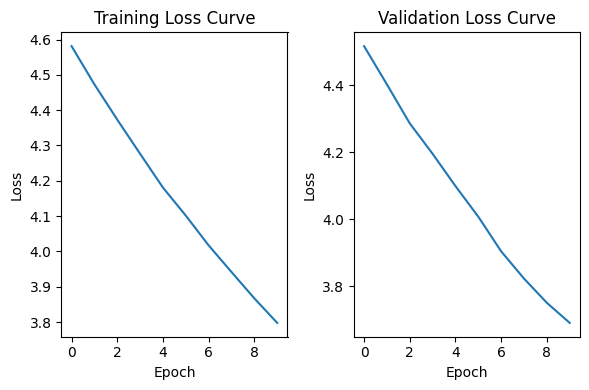

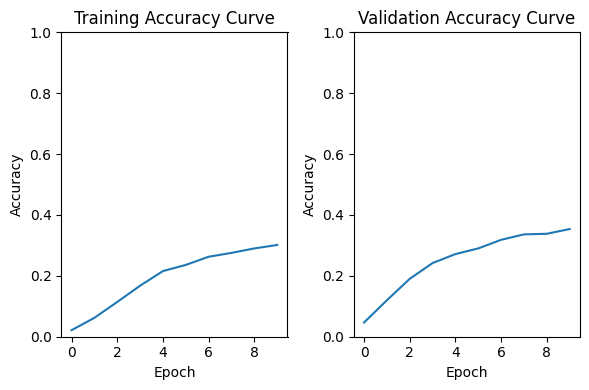

In [69]:
# Plot training results
plot_loss_curves(train_losses=results["training_losses"], val_losses=results["validation_losses"])
plot_accuracy_curves(train_accs=results["training_accuracies"], val_accs=results["validation_accuracies"])

In [73]:
# Set up MLFlow configuration
import mlflow
mlflow.set_experiment("Baseline EffNet B0 Model")
mlflow.set_tracking_uri("http://localhost:5000")

# Log training results to MLFlow
with mlflow.start_run():
    mlflow.log_params(training_params)
    mlflow.log_metrics({"best_training_loss" : results["training_losses"].max(),
                        "best_validation_loss" : results["validation_losses"].max(),
                        "best_training_acc" : results["training_accuracies"].max(),
                        "best_validation_acc" : results["validation_accuracies"].max()})
    mlflow.pytorch.log_model(effnet_b0_model, "EfficientNet B0")

KeyboardInterrupt: 